In [1]:
import sys
import torch 
sys.path.append("src")

In [2]:
from torch.utils.data import DataLoader
from dataloader import CollateFunctionSongDetection, SongDetectorDataClass


collate_fn = CollateFunctionSongDetection(segment_length=2048)

test_class = SongDetectorDataClass("/home/george-vengrovski/Documents/data/tweety_net_test")
test_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

train_class = SongDetectorDataClass("/home/george-vengrovski/Documents/data/tweety_net_train")
train_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

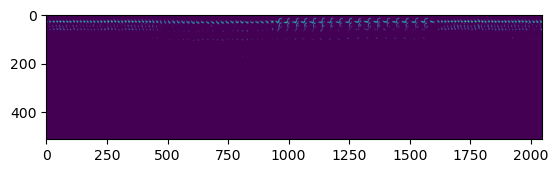

In [3]:
_, s = next(iter(test_loader))
import matplotlib.pyplot as plt

plt.imshow(_[0,0])

In [14]:
from model import TweetyNet
from trainer import Trainer 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TweetyNet(hidden_size=32, rnn_dropout=0.3, num_classes=1, input_shape=(1, 512, 2048))
model = model.to(device)

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Batch 100: FER = 1.54%, Train Loss = 0.0260, Val Loss = 0.0466
Batch 200: FER = 1.10%, Train Loss = 0.0988, Val Loss = 0.0004
Batch 300: FER = 1.13%, Train Loss = 0.0381, Val Loss = 0.0006
Batch 400: FER = 0.69%, Train Loss = 0.0332, Val Loss = 0.0007
Batch 500: FER = 1.00%, Train Loss = 0.0291, Val Loss = 0.0008
Batch 600: FER = 0.99%, Train Loss = 0.0273, Val Loss = 0.0009
Batch 700: FER = 1.02%, Train Loss = 0.0250, Val Loss = 0.0011
Batch 800: FER = 1.09%, Train Loss = 0.0262, Val Loss = 0.0012
Batch 900: FER = 1.05%, Train Loss = 0.0307, Val Loss = 0.0014
Batch 1000: FER = 0.60%, Train Loss = 0.0340, Val Loss = 0.0015


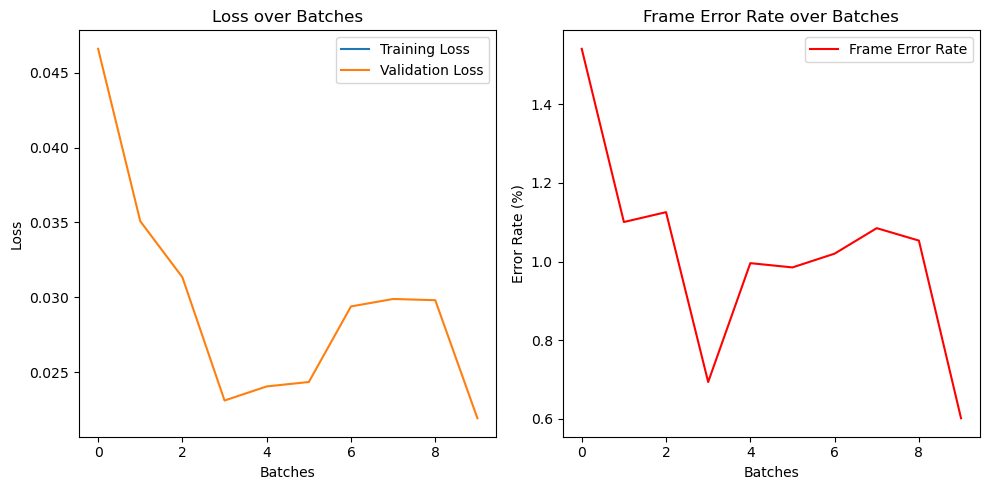

In [15]:
trainer = Trainer(model=model, train_loader=train_loader, test_loader=test_loader, device=device, lr=3e-4, plotting=True, batches_per_eval=100, desired_total_batches=1000, patience=16)
trainer.train()

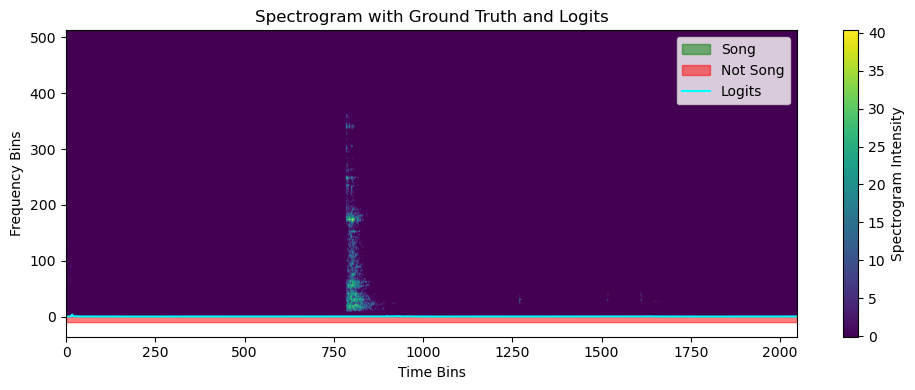

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply sigmoid to logits to scale them between 0 and 1
    logits_sigmoid = sigmoid(logits.squeeze().detach().cpu().numpy())  # Ensure logits is 1D before applying sigmoid

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as bars at the bottom
    times = np.arange(ground_truth_label.shape[0])
    song_bar_height = np.full_like(ground_truth_label.numpy(), -5)  # Slightly below the spectrogram
    not_song_bar_height = np.full_like(ground_truth_label.numpy(), -10)  # Further below for clarity

    plt.fill_between(times, song_bar_height, where=ground_truth_label.numpy() > 0.5, color='green', step='mid', alpha=0.5, label='Song')
    plt.fill_between(times, not_song_bar_height, where=ground_truth_label.numpy() <= 0.5, color='red', step='mid', alpha=0.5, label='Not Song')

    # Overlay logits as a line plot
    plt.plot(times, logits_sigmoid * (spec.shape[0] - 1), color='cyan', label='Logits')  # Scale logits to match spectrogram's frequency range

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `test_loader`, `model`, and `device` are defined and initialized in your code
spec, ground_truth_label = next(iter(test_loader))  # Get a batch from your DataLoader

logit = model(spec.to(device))  # Get model predictions

# Use the first example in the batch for plotting
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logit = logit[0]  # Adjust based on your model's output shape

# Remove channel dimension if present
if spec.dim() > 2:
    spec = spec.squeeze(0)

# Plot using the function
plot_spectrogram_with_labels_and_logits(spec.cpu(), ground_truth_label.cpu(), logit.cpu())


In [17]:
import os
import numpy as np
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def process_spectrogram(spec, max_length=2048):
    """
    Process the spectrogram in chunks, pass through the classifier, and return the binary predictions based on BCE.
    """
    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(spec.shape[1] / max_length))
    combined_predictions = []

    for i in range(num_chunks):
        # Extract the chunk
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, spec.shape[1])
        chunk = spec[:, start_idx:end_idx]
        # Forward pass through the model
        # Ensure chunk is on the correct device
        chunk_tensor = torch.Tensor(chunk).unsqueeze(0).unsqueeze(0).to(device)
        
        logits = model(chunk_tensor)
        logits = logits.squeeze().detach().cpu()
        logits = sigmoid(logits)

        combined_predictions.append(logits)

    # Concatenate all chunks' predictions
    final_predictions = np.concatenate(combined_predictions, axis=-1)

    return final_predictions

def process_files(src):
    """
    Process each file in the directory, reshape predictions, and overwrite the original files with the processed data.
    """
    files = os.listdir(src)
    for file in tqdm(files, desc="Processing files"):  # Wrap the loop with tqdm for progress tracking
        file_path = os.path.join(src, file)

        try:
            # Load the spectrogram from the file
            f = np.load(file_path, allow_pickle=True)
            spec = f['s']

            # Z-score normalization
            spec_mean = spec.mean()
            spec_std = spec.std()
            spec = (spec - spec_mean) / spec_std

            # Process the spectrogram and get predictions
            predictions = process_spectrogram(spec)

            # Overwrite the original file with the spectrogram and predictions
            np.savez(file_path, s=spec, song=predictions)  # Use the original `file_path` to overwrite

        except Exception as e:
            print(f"Failed to process file {file}: {str(e)}")

src = "/home/george-vengrovski/Documents/data/temp"
process_files(src)


Processing files:   0%|          | 0/215 [00:00<?, ?it/s]

Processing files: 100%|██████████| 215/215 [00:40<00:00,  5.37it/s]


KeyboardInterrupt: 

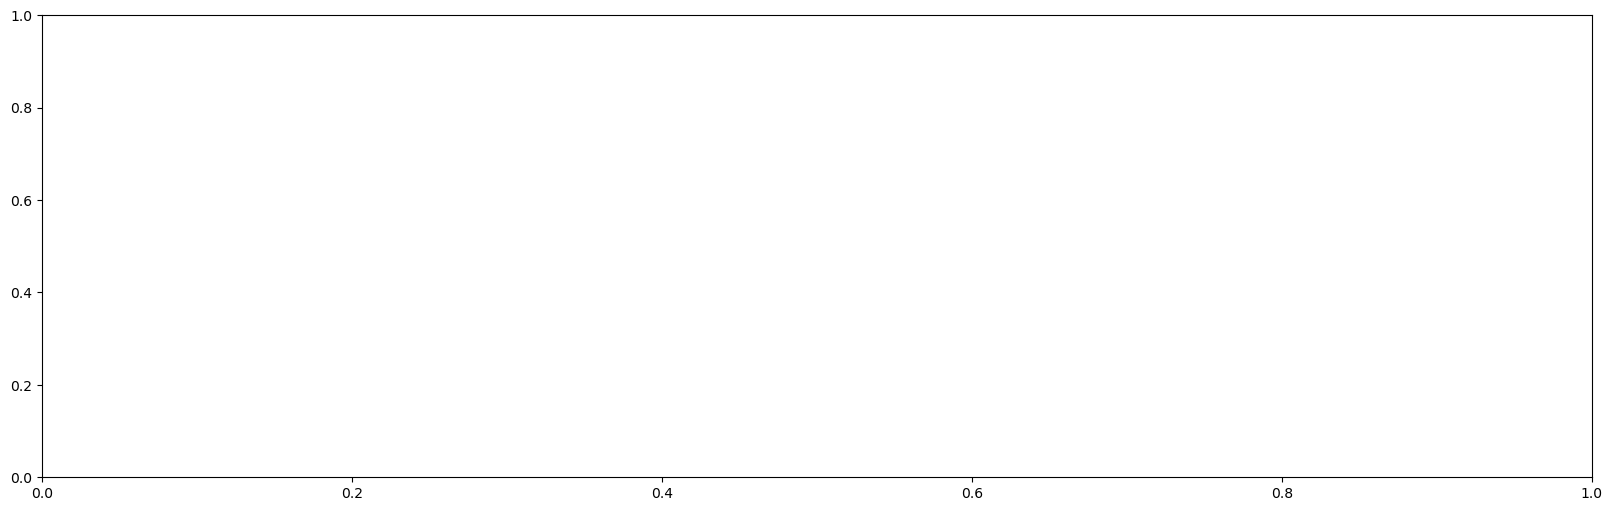

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os

def moving_average(signal, window_size):
    """Compute the moving average of the given signal with the specified window size."""
    cumsum_vec = np.cumsum(np.insert(signal, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

def plot_with_classification_line(src, output_dir):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(src)

    for file_name in files:
        file_path = os.path.join(src, file_name)
        f = np.load(file=file_path, allow_pickle=True)
        song = f['song']

        # Plotting
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.imshow(f['s'], aspect='auto', origin='lower')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')

        # # Plot original classification sigmoid line
        # times = np.arange(len(song))
        # ax.plot(times, song * (f['s'].shape[0] - 1), color='cyan', label='Original Classification Sigmoid')

        # Compute and plot smoothed line
        smoothed_song = moving_average(song, window_size=100)  # Apply moving average with a window size of 100
        smoothed_times = np.arange(len(smoothed_song)) + 50  # Offset times by half the window size for alignment
        ax.plot(smoothed_times, smoothed_song * (f['s'].shape[0] - 1), color='magenta', label='Smoothed Classification Sigmoid', alpha=0.7)

        # Adjust legend to include both lines
        ax.legend(loc='upper right')

        # Saving the plot
        output_file_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_detection.png")
        plt.savefig(output_file_path, bbox_inches='tight')
        plt.close(fig)

# Example usage
src = "/home/george-vengrovski/Documents/data/temp"
output_dir = "/home/george-vengrovski/Documents/projects/tweety_net_song_detector/sort_test"
plot_with_classification_line(src, output_dir)
